In [13]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# 1. FETCHING DATA

In [16]:
base_url = "http://localhost:5000"


def fetch_data(endpoint):
    response = requests.get(f"{base_url}/{endpoint}")
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Failed to fetch data from {endpoint}")

# Fetch data
vehicles_data = fetch_data('vehicles')
drivers_data = fetch_data('drivers')
trips_data = fetch_data('trips')
routes_data = fetch_data('routes')

# 2. DATA PRE-PROSESSING & CLEANING

In [17]:
# Convert raw data into pandas DataFrame
vehicles_df = pd.DataFrame(vehicles_data)
drivers_df = pd.DataFrame(drivers_data)
trips_df = pd.DataFrame(trips_data)
routes_df = pd.DataFrame(routes_data)

# Convert date columns to datetime type (example: maintenance date, trip start time)
vehicles_df['last_maintenance_date'] = pd.to_datetime(vehicles_df['last_maintenance_date'])
trips_df['start_time'] = pd.to_datetime(trips_df['start_time'])
trips_df['end_time'] = pd.to_datetime(trips_df['end_time'], errors='coerce')

# Handle missing values - example: filling nulls with appropriate strategies
vehicles_df.fillna({'fuel_efficiency': vehicles_df['fuel_efficiency'].median()}, inplace=True)
trips_df.fillna({'actual_duration': trips_df['expected_duration']}, inplace=True)
routes_df.fillna({'historical_delays': routes_df['historical_delays'].median()}, inplace=True)

# Drop columns that are not relevant for the analysis
trips_df.drop(columns=['delay_reason', 'incidents_reported'], inplace=True)

# Handle categorical variables (encoding if necessary)
drivers_df['certifications'] = drivers_df['certifications'].apply(lambda x: eval(x))  # Convert string list to actual list


# 3. DATA EXPLORATION

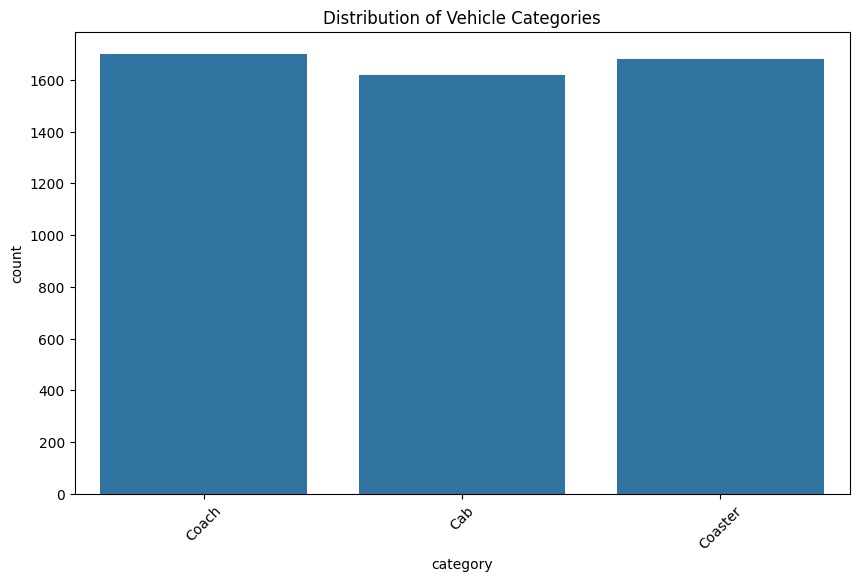

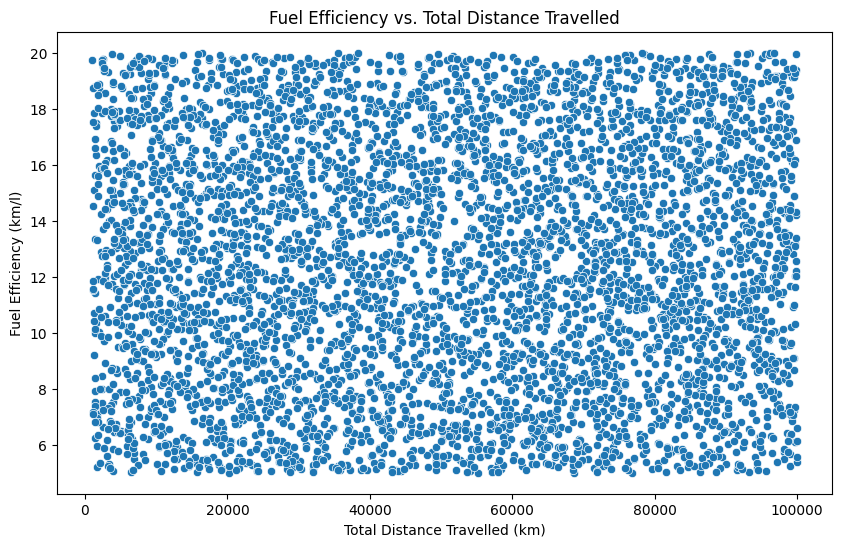

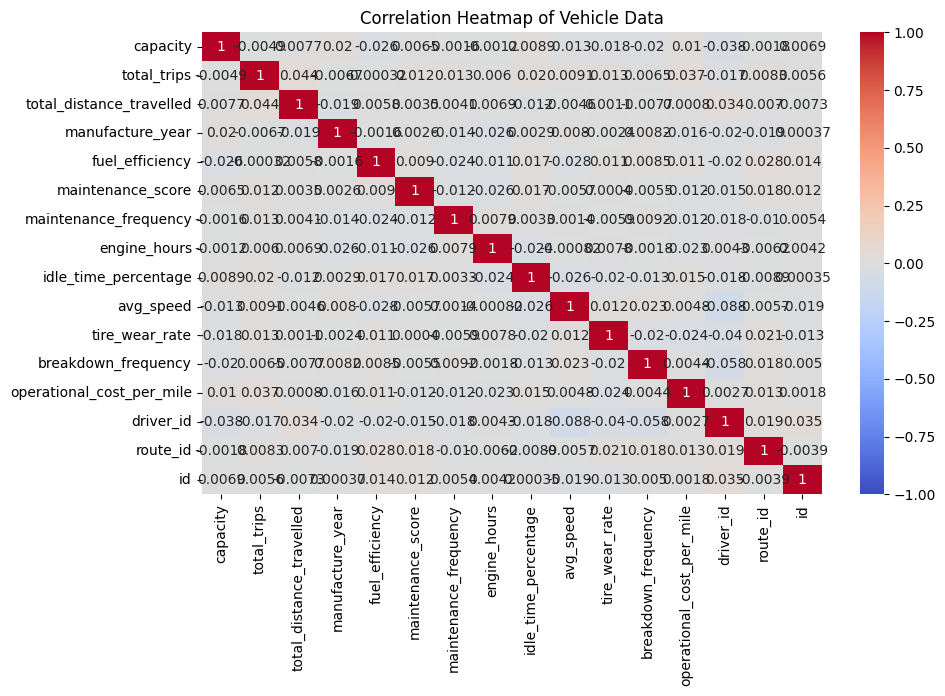

In [18]:
# Example: Plot the distribution of vehicle categories
plt.figure(figsize=(10, 6))
sns.countplot(x='category', data=vehicles_df)
plt.title('Distribution of Vehicle Categories')
plt.xticks(rotation=45)
plt.show()

# Plot fuel efficiency vs. total distance travelled
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_distance_travelled', y='fuel_efficiency', data=vehicles_df)
plt.title('Fuel Efficiency vs. Total Distance Travelled')
plt.xlabel('Total Distance Travelled (km)')
plt.ylabel('Fuel Efficiency (km/l)')
plt.show()

# Correlation heatmap for numerical variables
numeric_cols = vehicles_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = vehicles_df[numeric_cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Vehicle Data')
plt.show()


# 4. SAVE CLEANED DATA TO CSV

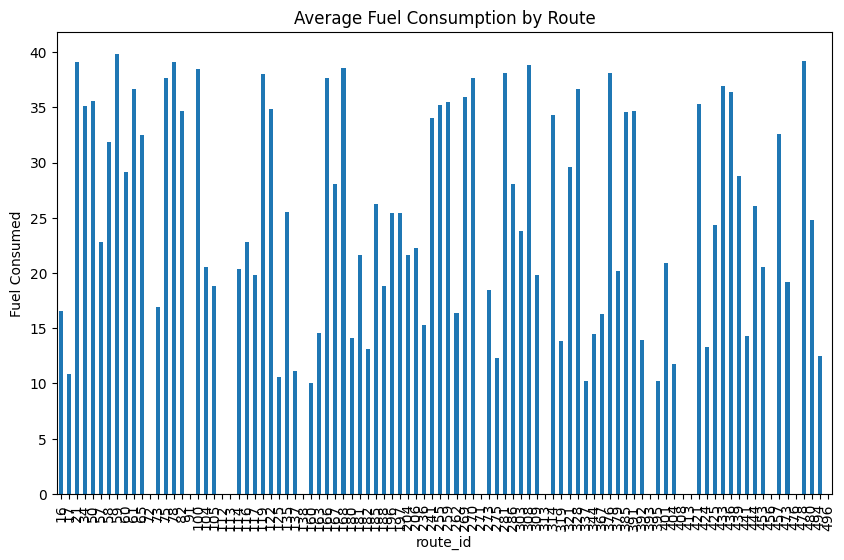

In [19]:
vehicles_df.to_csv('csv_datasets/vehicles_cleaned.csv', index=False)
drivers_df.to_csv('csv_datasets/drivers_cleaned.csv', index=False)
trips_df.to_csv('csv_datasets/trips_cleaned.csv', index=False)
routes_df.to_csv('csv_datasets/routes_cleaned.csv', index=False)

# 5. Further exploration (optional)
# For example, checking out the average fuel consumption by route or driver
avg_fuel_by_route = trips_df.groupby('route_id')['fuel_consumed'].mean()
avg_fuel_by_route.plot(kind='bar', figsize=(10, 6), title="Average Fuel Consumption by Route")
plt.ylabel('Fuel Consumed')
plt.show()

# 5. MERGE DATASETS

In [20]:
vehicles_df = pd.read_csv('csv_datasets/vehicles_cleaned.csv')
drivers_df = pd.read_csv('csv_datasets/drivers_cleaned.csv')
trips_df = pd.read_csv('csv_datasets/trips_cleaned.csv')
routes_df = pd.read_csv('csv_datasets/routes_cleaned.csv')

# Merge all the four datasets in reversed order
merged_df = pd.merge(routes_df, trips_df, left_on='id', right_on='route_id', how='inner')
merged_df = pd.merge(merged_df, drivers_df, left_on='driver_id', right_on='id', how='inner', suffixes=('_trips', '_drivers'))
merged_df = pd.merge(merged_df, vehicles_df, left_on='vehicle_id', right_on='id', how='inner', suffixes=('_merged', '_vehicles'))

merged_df = merged_df.rename(columns={
    'driver_id_merged': 'driver_id',
    'route_id_merged': 'route_id',
    'total_trips_vehicles': 'total_trips_vehicle',
    'total_trips_merged': 'total_trips_driver',
})

merged_df.to_csv('csv_datasets/merged_dataset.csv', index=False)
merged_df


,route_code,cost,start_location,end_location,estimated_travel_time,distance,avg_traffic_density,avg_fuel_consumption,historical_delays,weather_risk_factor,...,idle_time_percentage,avg_speed,emissions_data,tire_wear_rate,breakdown_frequency,sensor_data_json,operational_cost_per_mile,driver_id_vehicles,route_id_vehicles,id_vehicles
0,R016,326.568428,Butare,Gisenyi,10,484.949027,0.878648,11.143780,39.147325,0.178330,...,0.206305,58.798981,"{""co2"": 154.75406912127227, ""nox"": 28.48645017...",0.005196,0.004721,"{""engine_temp"": 197.8509188505155, ""oil_pressu...",1.995337,214.0,NaN,376
1,R017,102.399536,Kayonza,Kayonza,1,432.300916,0.755321,14.756230,7.583383,0.435853,...,0.076499,33.519388,"{""co2"": 207.4067685470776, ""nox"": 18.698130974...",0.008075,0.019773,"{""engine_temp"": 197.15600245429712, ""oil_press...",0.930485,191.0,192.0,641
2,R021,247.254230,Kirehe,Gicumbi,2,290.429649,0.406778,28.942904,34.718419,0.631059,...,0.213017,47.447184,"{""co2"": 127.46267643288797, ""nox"": 12.08502435...",0.003762,0.020072,"{""engine_temp"": 209.7949525598591, ""oil_pressu...",0.989433,79.0,317.0,692
3,R034,471.496057,Karongi,Musanze,9,332.453651,0.209353,18.433386,52.232811,0.701953,...,0.232645,41.115970,"{""co2"": 179.39755315708118, ""nox"": 47.49586076...",0.004291,0.020483,"{""engine_temp"": 206.97382178407395, ""oil_press...",1.802124,905.0,NaN,557
4,R050,268.713255,Musanze,Kayonza,3,71.142938,0.890387,12.400337,35.685665,0.738224,...,0.066951,41.923446,"{""co2"": 210.47027848023615, ""nox"": 17.93987978...",0.008876,0.044987,"{""engine_temp"": 194.75910546756222, ""oil_press...",1.618396,564.0,331.0,922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,R476,196.270846,Gisenyi,Rwamagana,1,254.932585,0.122866,10.205132,28.885848,0.727440,...,0.210880,32.797225,"{""co2"": 199.02670551903825, ""nox"": 21.22560691...",0.002528,0.014602,"{""engine_temp"": 181.9387628341862, ""oil_pressu...",0.926350,713.0,184.0,191
96,R478,432.845833,Gisenyi,Nyanza,6,148.728573,0.767008,11.661212,18.585159,0.697265,...,0.239006,56.785461,"{""co2"": 139.44744165301782, ""nox"": 39.49479307...",0.005204,0.019161,"{""engine_temp"": 215.8035088682784, ""oil_pressu...",1.948213,32.0,450.0,1242
97,R480,328.791123,Kirehe,Kamonyi,3,428.836746,0.771483,17.469283,23.886066,0.788803,...,0.143460,58.816994,"{""co2"": 179.30203888522888, ""nox"": 19.09309480...",0.006611,0.044971,"{""engine_temp"": 210.02416037016488, ""oil_press...",1.746017,350.0,429.0,1028
98,R494,438.677293,Nyundo,Kirehe,1,298.509308,0.894631,17.545739,23.322753,0.693784,...,0.297520,51.086570,"{""co2"": 297.53586225678396, ""nox"": 32.04820047...",0.004378,0.004754,"{""engine_temp"": 185.92760673239653, ""oil_press...",0.687858,424.0,378.0,1088


# 6. FEATURE ENGINEERING

In [21]:
print(merged_df.isnull().sum())


route_code                    0
cost                          0
start_location                0
end_location                  0
estimated_travel_time         0
                             ..
sensor_data_json              0
operational_cost_per_mile     0
driver_id_vehicles            0
route_id_vehicles            30
id_vehicles                   0
Length: 82, dtype: int64


In [10]:
merged_df['start_time'] = pd.to_datetime(merged_df['start_time'])
merged_df['end_time'] = pd.to_datetime(merged_df['end_time'])

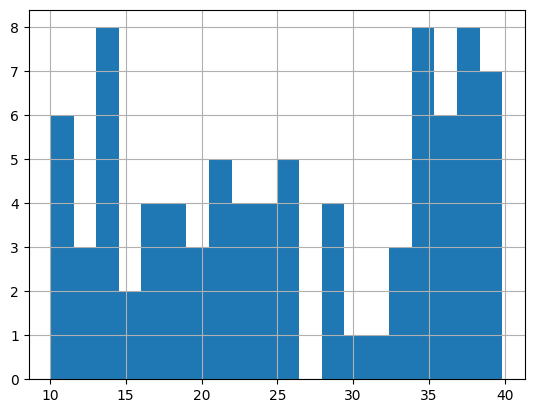

In [22]:
merged_df['fuel_consumed'].hist(bins=20)
plt.show()

In [23]:
print(merged_df[['actual_distance', 'average_speed']].describe())

       actual_distance  average_speed
count        86.000000      86.000000
mean        265.363316      87.701793
std         126.814507     102.593880
min          53.728416       5.883169
25%         177.838239      29.587955
50%         247.984540      50.365258
75%         350.471423      96.661693
max         521.260478     510.039256
